In [1]:
import os, sys

# I will use my own packet named "from_scratch" that is an implementation of a deep learning framework using simple numpy functions
# You can find all scripts here : https://github.com/RomainGrx/deep-learning-from-scratch

# Add the github repo in the path
fs_path = os.path.join(os.getcwd(), "deep-learning-from-scratch")
if fs_path not in sys.path:
    sys.path.append(fs_path)
    
import from_scratch as fs
from from_scratch.models import Sequential
from from_scratch import layers, losses, optimizers
import numpy as np

XOR problem 
===


In [2]:
X_xor = np.array([[0,0], [0,1], [1,0], [1,1]])
y_xor = np.array([0, 1, 1, 0]).reshape(-1, 1)

In [3]:
# Given data 
Wxh = np.array([[.79, 1.34], [.87, 1.08]])
bh = np.array([.10, -1.12])
Why = np.array([[.68], [-2.01]])
by = np.array([-.3])

model = Sequential([
    layers.Dense(2, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model.compile(
    losses.Crossentropy(),
    optimizers.GradientDescent(lr=0.2),
)

# Needed to initialize all layers, weights, ...
dry_run = model.forward(X_xor)

# Fix the weights and biases
# layers[0] = x->h layer
# layers[1] = the ReLU activation layer
# layers[2] = h->y layer
# layers[3] = Sigmoid activation layer
model.layers[0].weights = Wxh
model.layers[0].biases = bh
model.layers[2].weights = Why
model.layers[2].biases = by

print(model.summary())

+----------------------+-------------+--------------+---------------+
|      Layer Name      | Input Shape | Output Shape | Nb Parameters |
+----------------------+-------------+--------------+---------------+
|        Dense         |  (None, 2)  |  (None, 2)   |       6       |
|  Activation (relu)   |  (None, 2)  |  (None, 2)   |       0       |
|        Dense         |  (None, 2)  |  (None, 1)   |       3       |
| Activation (sigmoid) |  (None, 1)  |  (None, 1)   |       0       |
+----------------------+-------------+--------------+---------------+
Total parameters : 9


Question 1 : Forward propagation
---

In [4]:
y_hat = model.forward(X_xor)
print("Outputed y_hat :: ", ", ".join(["%.3f"%v for v in y_hat]))

Outputed y_hat ::  0.442, 0.589, 0.466, 0.152


Question 2 : Classification
---

How many examples are correctly classified with the current network?

In [5]:
def xor_correct(y_hat):
    y_hat_rounded = np.round(y_hat)
    return np.sum(y_xor == y_hat_rounded)

n_corrects = xor_correct(y_hat)
print("Number of correctly classified :: %d"%n_corrects)

Number of correctly classified :: 3


Question 3 : Loss
---

What is the value of the cross-entropy loss $L(\hat{y}, y)$ computed from the 4 examples using this network? This cross-entropy loss is the cost function $J$ of the network, which depends on the network parameters.

In [6]:
loss_fn = fs.losses.Crossentropy()
loss = np.sum(loss_fn(y_xor, y_hat))
print("Binary crossentropy loss :: %.3f"%loss)

Binary crossentropy loss :: 2.043


Question 4 : Back-propagation
---

In order to update the weights of our model, we will back-propagate one example, namely $x_3 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$, $y_3=1$.

First, we need to compute the output layer gradient $\nabla{\hat{y}}J$. What is its value when considering this example ?

In [7]:
x3, y3 = np.array([[1, 0]]), np.array([[1]])

y_hat3 = model.forward(x3)
loss_grad = loss_fn.gradient(y3, y_hat3)[0,0]
print(f'Ouput gradient :: {loss_grad:.3f}')

Ouput gradient :: -2.147


Question 5 : Back-propagation (continued) 
---

Consequently, what are the values of $\nabla_{W_{h \rightarrow y}} J$ and $\nabla_{b_{y}} J$, i.e. the gradients of the weight vectors and the bias of the last layer?

Give your answer using the format *grad_w_1*, *grad_w_2*, *grad_b*.

In [8]:
sigmoid_grad = model.layers[-1].backward(loss_grad)
Why_grad = model.layers[-2].backward(sigmoid_grad, get_all=True)

grad_w_hy = Why_grad["weights"]
grad_b_hy = Why_grad["biases"]

print(f'grad_w_1, grad_w2, grad_b :: {grad_w_hy[0,0]:.3f}, {grad_w_hy[1,0]:.3f}, {grad_b_hy[0,0]:.3f}')

grad_w_1, grad_w2, grad_b :: -0.475, -0.118, -0.534


Question 6 :  Back-propagation (continued) 
---

Next, we need to back-propagate the gradient to the hidden layer.

What is the value of $\nabla_h J$ ?

Give your answer using the format *grad_h_1*, *grad_h_2*.

In [9]:
print(f'grad_h_1, grad_h_2 :: {Why_grad["inputs"][0,0]:.3f}, {Why_grad["inputs"][0,1]:.3f}')

grad_h_1, grad_h_2 :: -0.363, 1.074


Question 7 : 
---

What are the values of $\nabla_{W_{x \rightarrow h}} J$ and $\nabla_{b_h} J$ , i.e. the gradients of the weight matrix and the bias vector of the first layer?

Give your answer using the format *grad_w_11*, *grad_w_12*, *grad_w_21*, *grad_w_22*, *grad_b_1*, *grad_b_2*.

In [10]:
relu_grad = model.layers[-3].backward(Why_grad["inputs"])
Wxh_grad = model.layers[-4].backward(relu_grad, get_all=True)

grad_w_xh = Wxh_grad["weights"]
grad_b_xh = Wxh_grad["biases"]
print(f'grad_w_11, grad_w_12, grad_w_21, grad_w_22, grad_b_1, grad_b_2 :: {grad_w_xh[0,0]:.3f}, {grad_w_xh[0,1]:.3f}, {grad_w_xh[1,0]:.3f}, {grad_w_xh[1,1]:.3f}, {grad_b_xh[0,0]:.3f}, {grad_b_xh[0,1]:.3f}')

grad_w_11, grad_w_12, grad_w_21, grad_w_22, grad_b_1, grad_b_2 :: -0.363, 1.074, 0.000, 0.000, -0.363, 1.074


Question 8 : Weight update
---

Using your previous answers, you can update the weights of the neural network. What are the new parameters $W_{h \rightarrow y}$ and $b_y$

of the last layer?

Give your answer using the format *w_1*, *w_2*, *b*.

In [11]:
# The backward pass already update the weights thanks to the optimizer in the model.compile
# but we can still calculate from scratch 
[[w_hy_1], [w_hy_2]] = model.layers[-2].weights
[[b_hy]] = model.layers[-2].biases

# From scratch with the gradient descent rule 
[[new_w_hy_1], [new_w_hy_2]] = Why - .2* grad_w_hy
[[new_b_hy]] = by - .2* grad_b_hy

# Verify we have the same variables
assert new_w_hy_1 == w_hy_1
assert new_w_hy_2 == w_hy_2
assert new_b_hy == b_hy

print(f'w_1, w_2, b :: {w_hy_1:.3f}, {w_hy_2:.3f}, {b_hy:.3f}')

w_1, w_2, b :: 0.775, -1.986, -0.193


Question 9 : Weight update (continued)
---

What are the new parameters $W_{x \rightarrow h}$ and $b_h$ of the first layer?

Give your answer using the format *w_11*, *w_12*, *w_21*, *w_22*, *b_1*, *b_2*.

In [12]:
Wxh = model.layers[0].weights
bh = model.layers[0].biases
print(f'w_11, w_12, w_21, w_22, b_1, b_2 :: {Wxh[0,0]:.3f}, {Wxh[0,1]:.3f}, {Wxh[1,0]:.3f}, {Wxh[1,1]:.3f}, {bh[0,0]:.3f}, {bh[0,1]:.3f}')

w_11, w_12, w_21, w_22, b_1, b_2 :: 0.863, 1.125, 0.870, 1.080, 0.173, -1.335


Question 10 :  Forward propagation 
---

Now, we will evaluate whether our model has been improved thanks to the back-propagation.

Propagate each example $x_i$ through the neural network.

How are these examples represented in the hidden space?

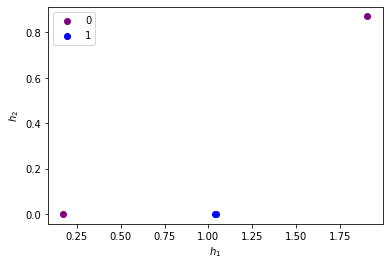

In [13]:
import matplotlib.pyplot as plt

h = model.layers[1].forward(model.layers[0].forward(X_xor))
y = np.round(model.forward(X_xor)).reshape(-1)

zeros = y == 0

plt.figure()
plt.xlabel(r"$h_1$")
plt.ylabel(r"$h_2$")
plt.scatter(h[zeros,0], h[zeros,1], color="purple", label="0")
plt.scatter(h[~zeros,0], h[~zeros,1], color="blue", label="1")
plt.legend()
plt.show()

Question 11: Forward propagation (continued) 
---

Are they linearly separable?

Yes

Question 12: Forward propagation (continued)
---

What are the values of the outputs $\hat{y_i}$?

Give your answer using the format y_1, y_2, y_3, y_4.

In [14]:
y_hat = model.forward(X_xor)

print("y_1, y_2, y_3, y_4 :: ", ", ".join(["%.4f"%v for v in y_hat.reshape(-1)]))

y_1, y_2, y_3, y_4 ::  0.4852, 0.6491, 0.6478, 0.3904


Question 13: Classification 
---

How many examples are correctly classified with the updated network?

In [15]:
print(xor_correct(y_hat))

4


Question 14: Loss 
---

What is the cross-entropy loss with the updated network?

In [16]:
loss = np.sum(model.loss_function(y_xor, y_hat))
print(f"Loss :: {loss:.3f}")

Loss :: 2.025


Question 15: Conclusion 
---

Check all the valid affirmations.

Final y_hat ::  0.000, 1.000, 1.000, 0.000


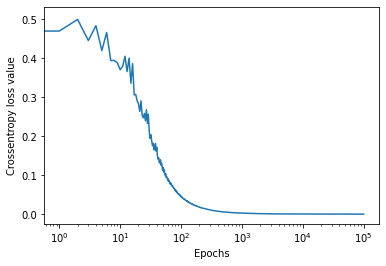

In [17]:
history = model.fit(X_xor, y_xor, epochs=1e5, verbose=0)
final_y = model.forward(X_xor).reshape(-1)

print("Final y_hat :: ", ", ".join(["%.3f"%v for v in final_y]))

plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss value")
plt.semilogx(history["epochs"], history["loss"])
plt.show()

- [x] The gradient descent algorithm will continue iterating to decrease the loss, until the latter converges
- [ ] Since all the examples are correctly classified, the gradient descent algorithm will stop at this point, as the model can no longer be improved
- [x] If we let the gradient descent algorithm continue, we could expect it to optimise the network to a point where the output values would be something like $\hat{y_1}=0.01$, $\hat{y_2}=0.99$, $\hat{y_3}=0.99$, $\hat{y_4}=0.01$  
- [ ] The gradient descent algorithm will always converge to the same point, regardless of the initial values of the network parameters.